# ORIE 5355/INFO 5370 HW 2: Recommendation systems

 - Name: Joy Wang
 - Net-id: zw673
 - Date: Sep.25th
 - Late days used for this assignment:0
 - Total late days used (counting this assignment):1
 - People with whom you discussed this assignment: 

After you finish the homework, please complete the following (short, anonymous) post-homework survey: https://forms.gle/toCDaWjfiEq5hYv76 and include the survey completion code below.

### Question 0 [1 points]
<font color='blue'> Survey completion code: hw22022xyz

We have marked questions in <font color='blue'> blue </font>. Please put answers in black (do not change colors). You'll want to write text answers in "markdown" mode instead of code. In Jupyter notebook, you can go to Cell > Cell Type > Markdown, from the menu. Please carefully read the late days policy and grading procedure [here](https://orie5355.github.io/Fall_2021/assignments/). 

# Conceptual component

Go through the "Algorithms tour" [here](https://algorithms-tour.stitchfix.com/). It's a great view of the combination of algorithms used by a modern e-commerce company. 

<font color='blue'> 1) How do they use a combination of "latent" factors and explicit features to gain the benefits of collaborative filtering (matrix factorization) while not being susceptible to cold start issues?

As their buyers and designers capture dimension and style details and their clients fill out a profile upon signup, they gain a lot of explicit data so that not being susceptible to cold start issues.
They infer some particularly pertinent latent features of both clients and styles from other data, such as clients' fit feedback and purchase histories. Also, they use natural language processing and they have machines look at photos of clothing that customers like (e.g. from Pinterest), and look for visually similar items in inventory.

<font color='blue'> 2) How do they match clients with human stylists who make the final decision? Does it remind you of anything we learned in class?

They calculate a match score between each available stylist and each client using a complex function of the history between that client and stylist, and the affinities between the client's stated and latent style preferences and those of the stylist.This reminders me of making multi-sided preferences using stable matching in class.

Also, they re-run the optimization problem much more frequently to account for the varying sizes of stylists' queues as they work. This reminders me of dealing with capacity constraints in class.

<font color='blue'> 3) How do they manage their inventory to ensure that they have enough items that future customers will want?

They try to understand clients' states and their needs when in those different states. Then they detect changes in state and consider possible triggers, so that they can develop state transition matrices and Markove chain models helping manage inventory.
They use a model of the system dynamics, fitting it to historical data and using it for robust optimization given quantified uncertainties in their forecasts.

# Programming component

## Helper code

In [68]:
import numpy as np
import pandas as pd
import os, sys, math
import matplotlib.pyplot as plt
import pickle
def load_pickle(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

def load_ratings_and_factors(type_name = 'rating_all_zero'):
    # ratings = load_pickle('data/{}_ratings'.format(type_name))
    book_vectors = load_pickle('data/{}_dict_book_factor'.format(type_name))
    user_vectors = load_pickle('data/{}_dict_reader_factor'.format(type_name))
    return book_vectors, user_vectors

In this homework, we are giving you trained user and book item vectors using a GoodReads dataset. Goodreads is a social cataloging website that allows individuals to search its database of books, annotations, quotes, and reviews. There are multiple types of interactions that a user can have with a book: add books to a list of books they intend to read ("short-list" the book), indicate they have read books before, and review books they have read. A user may have interacted with a book, even if they never left any explicit rating or review. Ratings actually left by users range from 1 to 5 (stars), with 5 being the most positive and 1 being the most negative.

Here, we work with multiple types of data that capture interactions between books and users as training data for a recommendation system. For each "type" of rating data, we give you the raw ratings data, as well as user and item vectors trained using a Python package (https://berkeley-reclab.github.io/) that implements matrix factorization in cases where there are missing entries in a matrix. The "ratings" data is in a "sparse matrix"/dictionary format, meaning that the dictionary keys are of the kind (user, item), and the dictionary value is the corresponding value. Not all pairs are in the matrix, indicating that that value is missing or at its default value. 

There are 2 types of rating/interaction data:
  
 - `Rating_all_missing_zero`: Numeric values more than 0 indicate the star ratings given. Missing values are replaced with 0's, so that there are no missing ratings. In another word, if a user has not left any reviews for a book, we assume that the user would rate the book 0 star.
 
 - `Rating_interaction_zero`: Numeric values more than 0 indicate the ratings given. Now, we replace missing values with 0's, _only if the user interacted with that book in the past_. In other words, if a user has not left any reviews for a book *and* has interacted with the book, we assume that the user would rate the book 0 star. Note that after such replacement, we would still get some missing values, since not all users have interacted with all the books.

In [69]:
book_vectors_allmissing0, user_vectors_allmissing0 = load_ratings_and_factors(type_name = 'rating_all_zero')
book_vectors_interact0, user_vectors_interact0 = load_ratings_and_factors(type_name = 'rating_interaction_zero')

In [70]:
def get_shapes_and_ranges(book_vectors, item_vectors):
    print(np.shape(book_vectors), np.shape(item_vectors))

In [71]:
get_shapes_and_ranges(book_vectors_allmissing0, user_vectors_allmissing0)
get_shapes_and_ranges(book_vectors_interact0, user_vectors_interact0)

(200, 10) (1000, 10)
(200, 10) (1000, 10)


## Problem 1: Predictions and recommendations with different data types

### 1a) What do different data types mean?

<font color='blue'> What is `Rating_interaction_zero` trying to capture -- why would we fill in books that someone interacted with but did not rate as a 0? (Hint: connect to conceptual reading from HW1). Answer in no more than 3 sentences. 

It is sometimes more costly to leave negative rather than positive feedback, which makes the feedback system biased. Those who interacted with books but didn't rate tend to have a lower rate than average. So we use Rating_interaction_zero to make a distinction between these people and others who have no interaction with books before.

<font color='blue'> What are some potential problems you see with using `Rating_all_missing_zero` for recommendations? Answer in no more than 3 sentences.
    
    

Replacing all missing values with zero means that those users have given the lowest possible rating to those books, which results in recommendations that do not accurately represent user preferences.
Also, it can lead to biased recommendations that favors items with more interactions over those with fewer interactions.
Besides, it exacerbates sparsity problem and may cause cold start problem.

### 1b) Generating predictions

<font color='blue'> Fill in the following function that takes in a user matrix (where each row is 1 user vector) and an item matrix (where each row is 1 item vector), and returns a matrix of predicted ratings for each user and item, where each entry is associated with the corresponding user (row number) and item (column number)

In [72]:
def get_predictions(user_vectors, book_vectors):
    predicted_ratings = np.dot(user_vectors,book_vectors.T)
    return predicted_ratings

<font color='blue'> Output the predictions for first 10 items for the first user, using each of the 2 data types.

For example, the predictions for one of the data types are:

Ratings for first 10 items, Ratings_all_missing_zero:

[ 0.08   0.29   0.063  1.57  -0.186  0.055  0.011 -0.088 -0.895 -0.012]

In [73]:
rates1=get_predictions(user_vectors_allmissing0,book_vectors_allmissing0)
rates2=get_predictions(user_vectors_interact0,book_vectors_interact0)
print(rates1[0][:10])
print(rates2[0][:10])

[ 0.08031172  0.28975416  0.06345163  1.5695302  -0.18567229  0.05502522
  0.01107722 -0.08822294 -0.89503553 -0.01175208]
[-1.00879311  4.16663033 -0.91856862 -0.30194806 -2.52606751 -0.18905701
 -3.08103904 -0.53718459 -1.18618829 -1.21838417]


<font color='blue'> Do a scatterplot of the predicted rating for two data types. (Each dot represents one user and one book, with X axis being predicted ratings using `Rating_interaction_zero` data and Y axis being predicted rating using `Rating_all_missing_zero` ratings). Describe what you see in no more than 2 sentences. 

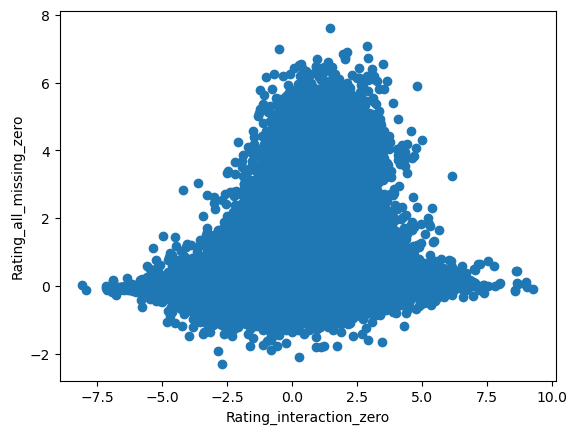

In [74]:
def get_shapes(book_vectors, item_vectors):
    return np.shape(book_vectors), np.shape(item_vectors)

import matplotlib.pyplot as plt
bookshape,usershape=get_shapes(book_vectors_allmissing0, user_vectors_allmissing0)
x=[]
y=[]
for i in range(usershape[0]):
    for j in range(bookshape[0]):
        x.append(rates2[i][j])
        y.append(rates1[i][j])

plt.scatter(x,y)

plt.xlabel("Rating_interaction_zero")
plt.ylabel("Rating_all_missing_zero")

plt.show()

### 1c) From predictions to recommendations (without capacity constraints)

<font color='blue'> Fill in the following function that takes in the matrix of predicted ratings for each user and item, and returns a dictionary where the keys are the user indices and the values are a list of length "number_top_items" indicating the recommendations given to that user

In [75]:
def get_recommendations_for_each_user(predictions, number_top_items = 10):
    dic={}
    pred_copy=np.copy(predictions)
    for i in range(predictions.shape[0]):
        dic[i]=[]
        n=0
        while n<number_top_items:
            max_index=np.argmax(pred_copy[i])
            dic[i].append(max_index)
            pred_copy[i][max_index]=float('-inf')
            n+=1
    return dic

<font color='blue'> Output the recommendations for the first user, using each of the 2 data types.

For example, from the `Ratings_all_missing_zero` dataset, you should get: [57, 55, 56, 81, 50, 78, 58, 86, 77, 96]

In [76]:
list1=get_recommendations_for_each_user(rates1,number_top_items = 10)
list2=get_recommendations_for_each_user(rates2,number_top_items = 10)
print("Ratings_all_missing_zero:",list1[0])
print("Rating_interaction_zero:",list2[0])

Ratings_all_missing_zero: [57, 55, 56, 81, 50, 78, 58, 86, 77, 96]
Rating_interaction_zero: [166, 53, 1, 111, 170, 74, 182, 37, 73, 52]


<font color='blue'> Fill in the following function that takes in the (top 10) recommendations for each user, and outputs a histogram for how often each item is to be recommended. For example, if there are 18 items, and 10 of them were never recommended, 5 of them were recommended once each, and 3 of them were recommended five times each, then you would have bars at 0, 1, and 5, of height 10, 5, and 3, respectively.

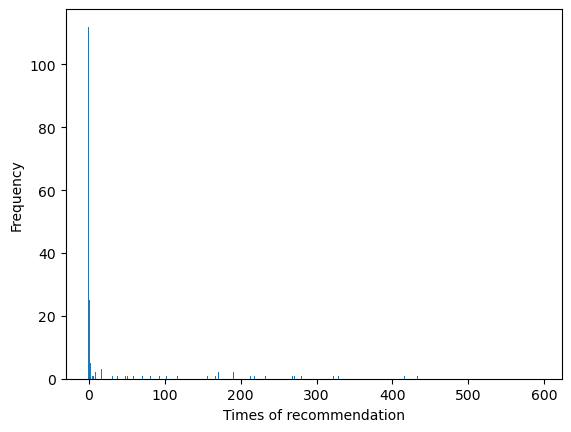

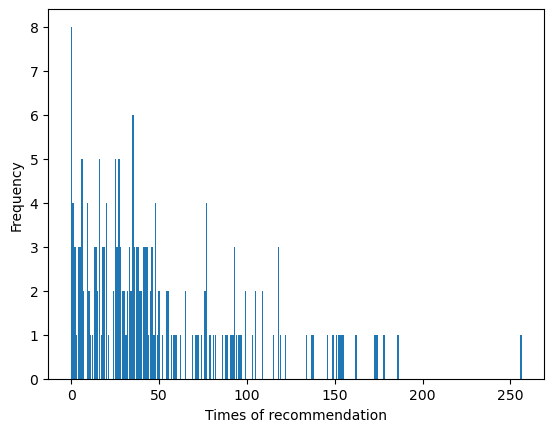

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [77]:
import collections

def show_frequency_histograms(recommendations):
    recom_items={}
    for i in recommendations.values():
        for j in i:
            if recom_items.get(j)==None:
                recom_items[j]=1
            else:
                recom_items[j]+=1

    frequencies = list(recom_items.values())
    fre_dict=collections.Counter(frequencies)
    for i in range(200):
        if i not in recom_items.keys():
            fre_dict[0]+=1
    
    x=list(fre_dict.keys())
    y=list(fre_dict.values())
    plt.bar(x,y)
    plt.xlabel('Times of recommendation')
    plt.ylabel('Frequency')
    plt.show()
    return plt
show_frequency_histograms(list1)
show_frequency_histograms(list2)

<font color='blue'> Show the histograms for both data types. Describe what you observe in no more than 3 sentences. For example, discuss how often is the most recommended item recommended, how that compares to the least recommended items, and what that could mean for recommendations in various contexts. 

In the histogram of dataset "rating_all_missiing_zero", the least recommended item never has been recommended, and the most recommended item has been recommended more than 350 times.There are more than 100 items have never been recommended, which makes it challenging to recommend new or less-known items to users, limiting the diversity of recommendations.
In the histogram of dataset "rating_interaction_zero", all items are recommended more evenly, better adapting to capacity constraints.

# Problem 2: Cold start -- recommendations for new users

In this part of the assignment, we are going to ask you to tackle the "cold-start" problem with matrix-factorization based recommendation systems. The above recommendation techniques worked when you had access to past data for reach user, such as interactions or explicit ratings. However, it doesn't work as well when a new user has just joined the platform and so the platform doesn't have any data.  

You should also see a comma-separated values file (user_demographics.csv) that contains basic demographic information on each user. Each row describes one user, and have four attributes: 'User ID', 'Wealth', 'Age group' and 'Location'.

User ID is the unique identifier associated with each user, and it is in the same order as the user_vectors, and in the same indexing as the ratings (be careful about 0 and 1 indexing in Python).

Wealth is a non-negative, normalized value indicating the average wealth of the neighborhood in which the user is, where we normalized it such that each Location has similar wealth distributions. Age group describes the age of the user. Location describes the region that the user is from.

In [78]:
demographics = pd.read_csv("data/user_demographics.csv")
demographics.head()

,User ID,Wealth,Age group,Location
0,1,1.833101,50 to 64,America
1,2,2.194996,18 to 34,America
2,3,2.216195,18 to 34,Europe
3,4,0.838690,50 to 64,Asia Pacific
4,5,2.109313,18 to 34,America


We are now going to pretend that we don't have the personalized ratings/interactions history for the last 100 users, and thus don't have their user vectors. Rather, let's pretend that these are new users to the platform, and you are able to get the above demographics from their browswer cookies/IP address. Now, we're going to try to recommend items for them anyway. For this part, we'll exclusively use the `Rating_interaction_zero` data.

In [79]:
existing_user_vectors = user_vectors_interact0[0:900,:]
existing_user_demographics = demographics.iloc[0:900,:]
new_user_demographics = demographics.iloc[900:,:]

### 2a) Predictions for new users [Simple]

<font color='blue'> Fill in the following function that takes in: the demographics of a single new user, the demographics of all the existing users in your platform, and the user vectors of all the existing users, and outputs a 'predicted' user vector for the new user to use until we get enough data for that user. 
    
<font color='blue'> For this question, we ask you to use the following simple method to construct the vector for the new user. Each user is classified as "Low" or "High" wealth based on whether their Wealth score is below or above the median of about 1.70. Then, we simply construct a mean user vector for "Low" and "High" wealth, based on the 900 users (take the average vector among users with "Low" and "High" Wealth, respectively.). The correpsonding mean vector is then used for each new user. 

For example, using this method, you should find that the vector for the second user (index "1") is:

array([-0.183, -0.149, -0.141, -0.199, -0.166, -0.272, -0.02 ,  0.137,
       -0.12 ,  0.022])

Note: our answers below are based on the median _not rounded_ to 2 decimal places, i.e., we use the full median to many decimal places.

In [80]:
existing_user_demographics.Wealth.median()

1.7026180771992308

In [81]:
def get_user_vector_for_new_user(new_user, existing_user_demographics, existing_user_vectors):
    mid=existing_user_demographics.Wealth.median()
    high=[]
    low=[]
    for i in range(existing_user_vectors.shape[0]):
        if existing_user_demographics.Wealth[i]>=mid:
            high.append(existing_user_vectors[i])
        else:
            low.append(existing_user_vectors[i])



    avg_h=[]
    for j in range(len(high[0])):
        sumh=0
        for i in range(len(high)):
            sumh+=high[i][j]
        avg_h.append(sumh/len(high))

    avg_l=[]
    for j in range(len(low[0])):
        suml=0
        for i in range(len(low)):
            suml+=low[i][j]
        avg_l.append(suml/len(low))

    new_user_vectors=[]
    for i in range(new_user.shape[0]):
        if new_user.Wealth[900+i]>=mid:
            new_user_vectors.append(avg_h)
        else:
            new_user_vectors.append(avg_l)
    return new_user_vectors

In [82]:
new_user=get_user_vector_for_new_user(new_user_demographics, existing_user_demographics, existing_user_vectors)
print(new_user[1])

[-0.1826405719867348, -0.14885829817234567, -0.14115050600279888, -0.19928868128579724, -0.16599773954016595, -0.2724359920597968, -0.01999898170673064, 0.13722252087761794, -0.1197559344188566, 0.02165247013145053]


<font color='blue'> Output the mean vector predicted for the first user (index 0) in `new_user_demographics`. 

In [83]:
print(new_user[0])

[0.08780943150811217, -0.20709913353749781, -0.17762736410299737, -0.13094589164366768, -0.08942902403642827, -0.12702041629128474, -0.12242307839294987, -0.4268105867406346, -0.057752848850433, -0.10569089870005266]


<font color='blue'> For each of the 100 "new" users, use either your model to retrieve a user vector for that user, and then your functions from Problem 1 to get predicted ratings and top-10 recommendations. 

Plot a scatterplot between the ratings predicted by the demographic model and the ratings predicted by the full model from Problem 1. Each point in the scatter plot should correspond to one user and one item, and so your scatterplot should have 100*200 points.  

For example, for the first user-item pair (index 0 user, index 0 user), your prediction using the basic demographic should be -0.0011, and using the full model should be 0.3144. So one point in the scatter plot would be (-0.0011, 0.3144).

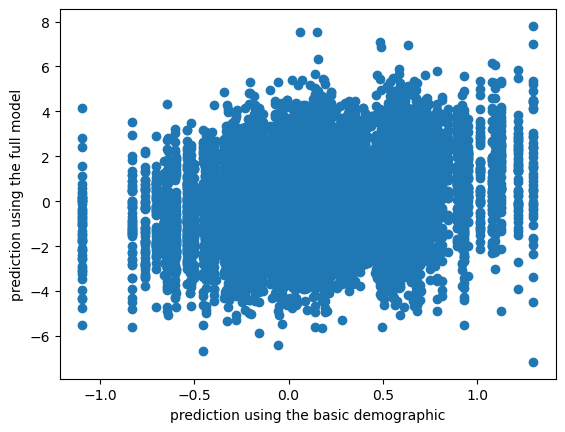

In [84]:
new_user_array=np.array(new_user)
rates_new=get_predictions(new_user_array,book_vectors_interact0)

list3=get_recommendations_for_each_user(rates_new,number_top_items = 10)
pltx=[]
plty=[]
for i in range(rates_new.shape[0]):
    for j in range(rates_new.shape[1]):
        pltx.append(rates_new[i][j])
        plty.append(rates2[900+i][j])
plt.scatter(pltx,plty)
plt.xlabel('prediction using the basic demographic')
plt.ylabel('prediction using the full model')

plt.show()

<font color='blue'> Comment on the above. What is the potential "loss" from using demogprahics since we do not have access to the full data?

Users who get the same rating value when using the basic demographic data may actually have significantly different ratings. Using the basic demographic data to make predictions may ignore potential influencing factors, neglecting the specificity of user preferences. It cannot recommend items to someone with unique taste.

### 2b) [Bonus, 2 points] Predictions for new users [Using KNN or another model]

<font color='blue'> Fill in the following function that takes in: the demographics of a single new user, the demographics of all the existing users in your platform, and the user vectors of all the existing users, and outputs a 'predicted' user vector for the new user to use until we get enough data for that user. 
    
<font color='blue'> Now, use K nearest neighbors or some other machine learning method, and report the same things as in 2a.
    
<font color='blue'> Feel free to prepare data/train a model outside this function, and then use your trained model within the function.

In [85]:
def get_user_vector_for_new_user_knn(new_user, existing_user_demographics, existing_user_vectors):
    pass

<font color='blue'> Output the mean vector predicted for the first user in `new_user_demographics`. 

<font color='blue'> Justify your choice of model. If you used K nearest neighbors, then how did you decide upon your distance function? If you used another model, how does that model weight the different demographics in importance (either implicitly or explicitly)?

# Problem 3: Predictions under capacity constraints

Above, you should have observed that if we just recommend the top items for each user, some items get recommended quite a bit, and many items do not get recommended at all. Here, we are going to ask you to implement recommendations under capacity constraints.

Throughout this part, assume that you only have 5 copies of each item that you recommend, and that you will only recommend 1 item to each user. In other words, you cannot recommend the same item more than 5 times, and so there are exactly 1000 items in stock (representing 200 unique books) for your 1000 users. 

We'll continue exclusively using the "ratings with interaction0" data.

Now, let's assume that users are entering the platform sequentially in order of index. So the index 0 user comes first, index 1 user comes second, etc. 

### 3a) Naive recommendations under capacity constraints

<font color='blue'> First, let's pretend that we were naively recommending the predicted favorite item to each user. Of course, with unlimited capacity, each user would be recommended their predicted favorite. With capacity constraints, the favorite items of the users who come in later might already have reached their capacity, and so they have to be recommended an item further down their list. 
    
<font color='blue'> Do the following: simulate users coming in sequentially, in order of index. For each user, recommend to them their predicted favorite item that is still available. So the first user will get their favorite item, but the last few users will almost certainly not receive any of their top few predicted items. For each user, keep track of what the rank of the item that they were ultimately recommended was, according to the predicting ranking over items for that user.
    
For example, you'll see that the first user was recommended their favorite item, but the last user was recommended their 129th favorite item. 


<font color='blue'> Plot the resulting rankings in 2 ways: 1) A line plot, where the X axis is the user index and the Y axis is the rank of the item that they were recommended. and 2) A histogram of how often each rank shows up. (the X axis is the (binned) rank, and the Y axis is the count of that bin). 

<font color='blue'> In all cases, you will plot the rank according to the user's predicted ranking. 

the last user was recommended their 129 th favorite item


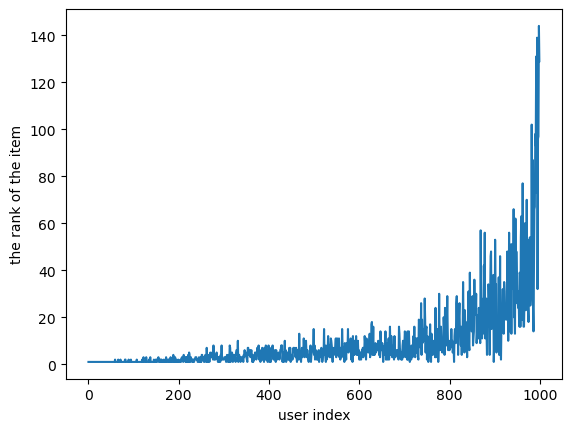

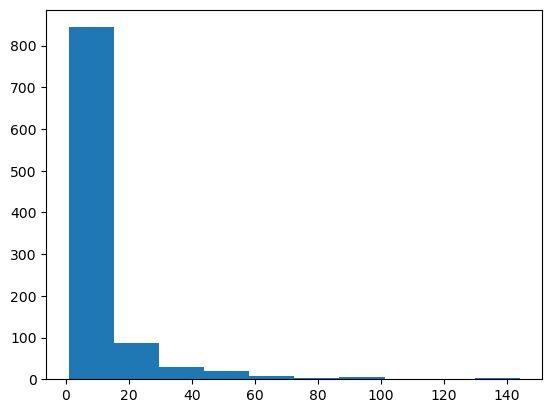

In [114]:
user_prefer_all=get_recommendations_for_each_user(rates2,number_top_items = 200)
no_storage=[]
dic_recom={}
count={}
for i in range(1000):
    j=0
    while j <200:
        if user_prefer_all[i][j] not in count.keys():
            dic_recom[i]=user_prefer_all[i][j]
            count[user_prefer_all[i][j]]=1
            break
        elif count.get(user_prefer_all[i][j])<5:
            dic_recom[i]=user_prefer_all[i][j]
            count[user_prefer_all[i][j]]+=1
            break
        else:
            j+=1
x=[]
y=[]
for i in range(1000):
    x.append(i)
    y.append(user_prefer_all[i].index(dic_recom[i])+1)
print("the last user was recommended their",user_prefer_all[999].index(dic_recom[999])+1,"th favorite item")
plt.plot(x,y)
plt.xlabel("user index")
plt.ylabel("the rank of the item")
plt.show()

fre_rank_dic=collections.Counter(y)
xfre=[]
yfre=[]
for i in fre_rank_dic.keys():
    xfre.append(i)
    yfre.append(fre_rank_dic[i])
    
plt.hist(y,bins=10)
plt.show()

### 3b) [Bonus -- 4 pts] Optimal recommendations under capacity constraints -- maximum weight matching

[2 points] <font color='blue'> Now let's do "optimal" recommendations with capacity, using maximum weight matching. Create the same two plots as above. <font color='blue'> Describe what you observe compared to the naive recommendations above. 
    
<font color='blue'>We suggest you use the `scipy.optimize.linear_sum_assignment` function. In that case, `np.tile` might also come in handy to create 5 copies of each items.  

[2 points] <font color='blue'> Of course, in reality you don't observe all the users at the same time -- they come in one by one, and you need to create a recommendation for the first user before the 50th user shows up. Here's let's pretend that users show up in batches of 100. So the first 100 users at the same time, next 100, etc. In this case, you can do "batched maximum weight matching," where you run maximum weight matching for the first 100 together to determine recommendations. Then, you do the same thing for the next 100 users with the items that are remaining, etc. 
    
<font color='blue'> Implement the above, show the same two plots as above, and describe what you observe. Note that this part requires careful attention for how many of each item remain after each round. 

### 3c) Score functions for recommendations under capacity constraints

<font color='blue'>Here, we are working with just 200 items and 1000 users, and so batched maximum weight matching is feasible to run. In practice, with millions of items, that  might not be an effective strategy. Now, we ask you to implement the score function approach from class.

<font color='blue'> You should normalize the predicted ratings between 0 and 1 so that you are not dividing by a negative or close to 0 average rating before proceeding.
    
<font color='blue'> Implement the above and run the same simulation as part 3a, show the same two plots, and describe what you observe.

Note that, as above, you will plot the rank according to the user's predicted ranking, NOT the score function ranking. (Plotting by score function ranking will result in just a straight line where everyone gets their top ranked item, which is incorrect).

<font color='blue'> For this part, use the following score function:
    
$$\frac{r_{ij}}{\bar{r_{j}}} \sqrt{C_j} $$

HINT: In your code, for each user $i$ you will:
1. Retrieve the ratings ${r_{ij}}$ for each item $j$. 
2. Normalize each  ${r_{ij}}$ for by mean item rating $r_j$ and multiply by the sqrt of the current capacity for that item. 
3. Sort the items by the above modified score, and recommend the best item according to the modified score.

In [104]:
import math
from sklearn import preprocessing
minmaxscaler=preprocessing.MinMaxScaler()
rates2_scaled=minmaxscaler.fit_transform(rates2)
rates2_score = np.zeros_like(rates2_scaled)

In [105]:
C={}
for j in range(200):
    C[j]=5
rj_matrix=rates2_scaled.mean(axis=0)
for i in range(1000):
    for j in range(200):
        rj=rj_matrix[j]
        rates2_score[i][j]=rates2_scaled[i][j]/rj*math.sqrt(C[j])
def get_user_like_score(C):
    for i in range(1000):
        for j in range(200):
            rj=rj_matrix[j]
            rates2_score[i][j]=rates2_scaled[i][j]/rj*math.sqrt(C[j])
    items_for_user=get_recommendations_for_each_user(rates2_score,number_top_items = 200)
    return rates2_score,items_for_user

In [106]:
num_users = 1000
num_items = 200

matched = {}
matched_user=[]
matched_rank=[]

while len(matched)<1000:
    user_like_scores, sorted_item_indices = get_user_like_score(C)
   
    for i, indices in sorted_item_indices.items():
        if i not in matched_user:
            j=0
            while C[indices[j]]<=0:
                j+=1
            value = user_like_scores[int(i)][indices[j]]  # 获取i用户第一个喜欢的物品序号，找到对应的得分

            matched[i]=indices[j]
            matched_user.append(i)
            C[indices[j]]-=1
            matched_rank.append(j)
            break
print(matched)

{0: 166, 1: 67, 2: 152, 3: 52, 4: 175, 5: 12, 6: 16, 7: 0, 8: 13, 9: 77, 10: 151, 11: 102, 12: 21, 13: 141, 14: 176, 15: 131, 16: 69, 17: 114, 18: 34, 19: 157, 20: 39, 21: 88, 22: 18, 23: 123, 24: 119, 25: 27, 26: 4, 27: 100, 28: 133, 29: 89, 30: 73, 31: 117, 32: 154, 33: 186, 34: 76, 35: 169, 36: 44, 37: 33, 38: 64, 39: 159, 40: 54, 41: 199, 42: 191, 43: 1, 44: 15, 45: 37, 46: 90, 47: 80, 48: 26, 49: 84, 50: 181, 51: 150, 52: 158, 53: 82, 54: 28, 55: 95, 56: 172, 57: 87, 58: 68, 59: 92, 60: 107, 61: 146, 62: 144, 63: 7, 64: 58, 65: 48, 66: 20, 67: 104, 68: 189, 69: 170, 70: 135, 71: 115, 72: 30, 73: 23, 74: 56, 75: 53, 76: 120, 77: 9, 78: 153, 79: 109, 80: 185, 81: 74, 82: 155, 83: 26, 84: 103, 85: 113, 86: 78, 87: 106, 88: 45, 89: 20, 90: 164, 91: 10, 92: 127, 93: 21, 94: 116, 95: 38, 96: 138, 97: 41, 98: 6, 99: 24, 100: 59, 101: 93, 102: 98, 103: 177, 104: 11, 105: 108, 106: 97, 107: 71, 108: 17, 109: 128, 110: 25, 111: 181, 112: 91, 113: 62, 114: 12, 115: 123, 116: 57, 117: 43, 118

In [107]:
print(matched_rank)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

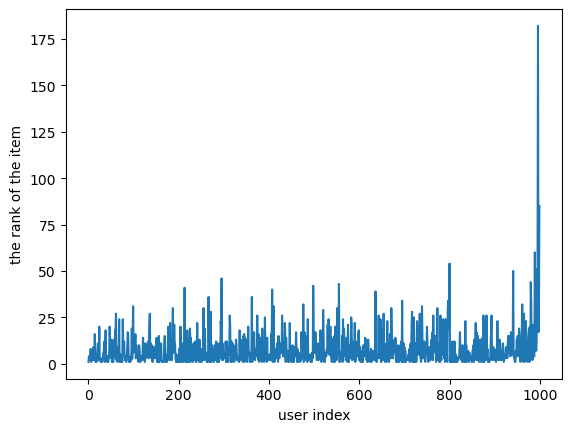

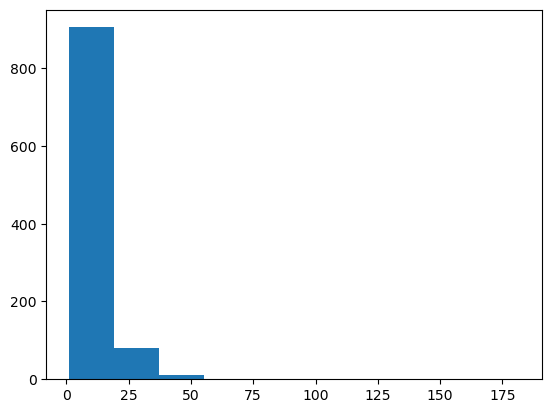

In [113]:
x3c=[]
y3c=[]
for item in matched:
    x3c.append(item)
    y3c.append(user_prefer_all[item].index(matched[item])+1)
plt.plot(x3c,y3c)
plt.xlabel("user index")
plt.ylabel("the rank of the item")
plt.show()
'''
fre_rank_dic_3c=collections.Counter(y3c)
xfre3c=[]
yfre3c=[]
for i in fre_rank_dic_3c.keys():
    xfre3c.append(i)
    yfre3c.append(fre_rank_dic_3c[i])
'''
plt.hist(y3c,bins=10)
plt.show()

In [109]:
print(y3c)

[1, 4, 3, 2, 5, 8, 1, 2, 2, 4, 2, 9, 2, 3, 16, 9, 1, 2, 1, 2, 5, 11, 4, 2, 20, 2, 3, 1, 2, 1, 1, 3, 3, 6, 6, 12, 1, 8, 18, 5, 3, 1, 4, 1, 1, 3, 6, 20, 10, 4, 3, 13, 1, 3, 2, 1, 4, 13, 4, 18, 17, 27, 2, 9, 1, 8, 8, 2, 24, 1, 4, 5, 1, 1, 3, 1, 24, 11, 6, 12, 4, 2, 4, 2, 1, 3, 9, 17, 16, 5, 1, 1, 1, 1, 4, 2, 19, 3, 15, 31, 6, 15, 13, 9, 16, 3, 10, 4, 3, 6, 5, 1, 10, 9, 4, 1, 4, 3, 2, 2, 6, 14, 6, 3, 2, 1, 11, 3, 7, 4, 5, 10, 12, 3, 13, 22, 27, 5, 11, 3, 10, 9, 1, 9, 5, 4, 9, 3, 3, 6, 8, 14, 1, 3, 2, 1, 15, 1, 4, 2, 5, 11, 2, 1, 1, 1, 1, 2, 8, 15, 1, 5, 3, 1, 1, 3, 12, 20, 3, 2, 5, 22, 5, 2, 2, 2, 11, 30, 6, 8, 21, 12, 10, 3, 1, 5, 4, 1, 3, 1, 1, 8, 5, 1, 20, 6, 5, 1, 11, 8, 1, 4, 3, 41, 3, 1, 4, 1, 4, 18, 1, 1, 1, 13, 7, 19, 1, 14, 3, 2, 2, 1, 4, 11, 2, 3, 12, 2, 1, 1, 4, 22, 2, 6, 5, 1, 13, 7, 3, 1, 8, 1, 4, 5, 4, 30, 2, 2, 19, 6, 6, 5, 1, 1, 1, 1, 36, 12, 3, 1, 5, 28, 1, 4, 10, 2, 8, 1, 1, 2, 10, 2, 8, 12, 5, 1, 3, 1, 11, 1, 4, 6, 3, 23, 20, 46, 2, 11, 2, 3, 6, 3, 4, 3, 12, 1, 1, 12, 2,

Comment for entire homework: In this homework, we haven't been careful with what is "training" data and what is "test" data. For example, in 3c, you're using average ratings from customers who haven't shown up yet in your simulation. In Problem 2, when training the user/book vectors we used data from customers that we are then pretending we haven't seen data from. In practice, and for the class project, you should be more careful. Such train/test/validation pipelines should be a core part of what you learn in machine learning classes. 